# Develop `second_narrows_current` Figure Module

Development of functions for `nowcast.figures.fvcom.second_narrows_current` web site figure module.

In [1]:
from pathlib import Path
import shlex
import subprocess
from types import SimpleNamespace

import arrow
import matplotlib.dates
import matplotlib.pyplot as plt
import numpy
import requests
import xarray
from salishsea_tools import unit_conversions

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_prep_plot_data()` Function

In [3]:
def _prep_plot_data(place, fvcom_stn_dataset):
    # FVCOM vertically averaged velocity component datasets
    stations = [
        name.decode().strip().split(maxsplit=1)[1] 
        for name in fvcom_stn_dataset.name_station.values
    ]
    fvcom_ua = fvcom_stn_dataset.ua.isel(station=stations.index(place))
    fvcom_ua.attrs.update({
        'long_name': 'u Velocity',
        'units': 'm/s',
    })
    fvcom_va = fvcom_stn_dataset.va.isel(station=stations.index(place))
    # FVCOM current speed and direction
    fvcom_speed = numpy.sqrt(fvcom_ua**2 + fvcom_va**2)
    fvcom_speed.name = 'fvcom_current_speed'
    fvcom_speed.attrs.update({
        'long_name': 'Current Speed',
        'units': 'm/s',
        'label': 'Model',
    })
    direction = numpy.arctan2(fvcom_va, fvcom_ua)
    fvcom_dir = numpy.rad2deg(direction + (direction < 0) * 2 * numpy.pi)
    fvcom_dir.name = 'fvcom_current_direction'
    fvcom_dir.attrs.update({
        'long_name': 'Current To Direction',
        'units': '°CCW from East',
        'label': 'Model',
    })
    shared.localize_time(fvcom_ua)
    shared.localize_time(fvcom_speed)
    shared.localize_time(fvcom_dir)
    return SimpleNamespace(
        fvcom_ua=fvcom_ua,
        fvcom_speed=fvcom_speed,
        fvcom_dir=fvcom_dir,
    )

Test `_prep_plot_data()`:

In [4]:
run_type = 'nowcast'
run_date = arrow.get('2018-09-07')

fvcom_stn_dataset_path_tmpl = (
    '/opp/fvcom/{run_type}/{ddmmmyy}/vhfr_low_v2_station_timeseries.nc'
)
if run_type == 'nowcast':
    fvcom_stn_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
else:
    nowcast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='nowcast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    forecast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='forecast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    fvcom_stn_dataset_path = Path('/tmp/vhfr_low_v2_station_timeseries_forecast.nc')
    cmd = (
        f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} '
        f'-o {fvcom_stn_dataset_path}'
    )
    subprocess.check_output(shlex.split(cmd))
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_stn_dataset_path} /tmp/{fvcom_stn_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_stn_dataset = xarray.open_dataset(f'/tmp/{fvcom_stn_dataset_path.name}')

plot_data = _prep_plot_data('2nd Narrows', fvcom_stn_dataset)

<xarray.DataArray 'ua' (time: 289)>
array([ 0.171131,  0.08646 ,  0.002303, ...,  1.068196,  1.004512,  0.937496], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-06T17:00:00 2018-09-06T17:05:00 ...
Attributes:
    long_name:  u Velocity
    units:      m/s
    type:       data
    tz_name:    PDT


/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


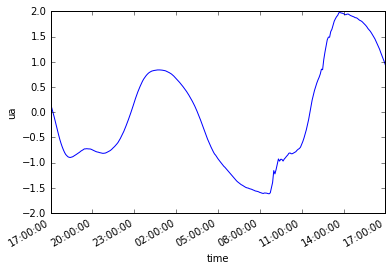

In [5]:
print(plot_data.fvcom_ua)
plot_data.fvcom_ua.plot()

<xarray.DataArray 'fvcom_current_speed' (time: 289)>
array([ 0.171279,  0.08664 ,  0.00458 , ...,  1.068474,  1.00478 ,  0.937751], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-06T17:00:00 2018-09-06T17:05:00 ...
Attributes:
    long_name:  Current Speed
    units:      m/s
    label:      Model
    tz_name:    PDT


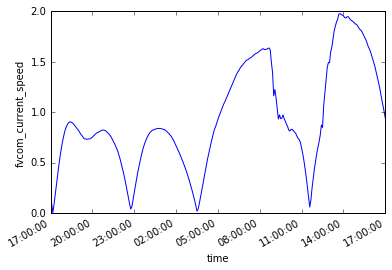

In [6]:
print(plot_data.fvcom_speed)
plot_data.fvcom_speed.plot()

<xarray.DataArray 'fvcom_current_direction' (time: 289)>
array([  2.380049,   3.693525,  59.809801, ...,   1.307781,   1.324475,
         1.335706])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-06T17:00:00 2018-09-06T17:05:00 ...
Attributes:
    long_name:  Current To Direction
    units:      °CCW from East
    label:      Model
    tz_name:    PDT


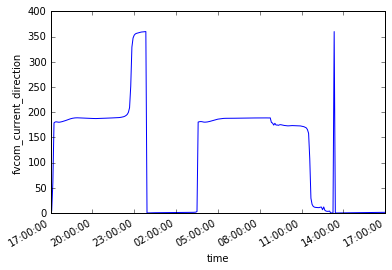

In [7]:
print(plot_data.fvcom_dir)
plot_data.fvcom_dir.plot()

## `_prep_fig_axes()` Function

In [8]:
def _prep_fig_axes(figsize, theme):
    fig, (ax_speed, ax_dir, ax_u) = plt.subplots(
        3, 1, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    ax_speed = {'mps': ax_speed}
    ax_speed['knots'] = ax_speed['mps'].twinx()
    ax_u = {'mps': ax_u}
    ax_u['knots'] = ax_u['mps'].twinx()
    fig.autofmt_xdate()
    return fig, (ax_speed, ax_dir, ax_u)

## `_plot_current_speed_time_series()` Function

In [9]:
def _plot_current_speed_time_series(ax, plot_data, theme):
    plot_data.fvcom_speed.plot(
        ax=ax['mps'],
        linewidth=2,
        color=theme.COLOURS['time series']['2nd Narrows model current speed'],
        label=plot_data.fvcom_speed.attrs['label']
    )


## `_current_speed_axes_labels()` Function

In [10]:
def _current_speed_axes_labels(ax, plot_data, theme):
    ax['mps'].set_title(
        'Current at 2nd Narrows',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    mps_limits = numpy.array((0, 5))
    ax['mps'].set_ylabel(
        f'{plot_data.fvcom_speed.attrs["long_name"]} '
        f'[{plot_data.fvcom_speed.attrs["units"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax['mps'].set_ylim(mps_limits)
    ax['knots'].set_ylabel(
        f'{plot_data.fvcom_speed.attrs["long_name"]} [knots]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax['knots'].set_ylim(unit_conversions.mps_knots(mps_limits))
    ax['mps'].legend(loc='best')
    ax['mps'].grid(axis='both')
    for k in ax:
        theme.set_axis_colors(ax[k])


## `_plot_current_direction_time_series()` Function

In [11]:
def _plot_current_direction_time_series(ax, plot_data, theme):
    plot_data.fvcom_dir.plot(
        ax=ax,
        linewidth=2,
        color=theme.COLOURS['time series']['2nd Narrows model current direction'],
        label=plot_data.fvcom_speed.attrs['label']
    )


## `_current_direction_axes_labels()` Function

In [12]:
def _current_direction_axes_labels(ax, plot_data, theme):
    ax.set_ylim(0, 360)
    ax.set_yticks((0, 45, 90, 135, 180, 225, 270, 315, 360))
    ax.set_yticklabels(('E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE', 'E'))
    ax.set_ylabel(
        f'{plot_data.fvcom_dir.attrs["long_name"]} ',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.legend(loc='best')
    ax.grid(axis='both')
    theme.set_axis_colors(ax)


## `_plot_u_velocity_time_series()` Function

In [13]:
def _plot_u_velocity_time_series(ax, plot_data, theme):
    plot_data.fvcom_ua.plot(
        ax=ax['mps'],
        linewidth=2,
        color=theme.COLOURS['time series']['2nd Narrows model current speed'],
    )


## `_u_velocity_axes_labels()` Function

In [17]:
def _u_velocity_axes_labels(ax, plot_data, theme):
    ax['mps'].set_xlabel(
        f'Time [{plot_data.fvcom_ua.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax['mps'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    mps_limits = numpy.array((-4, 4))
    ax['mps'].set_ylabel(
        f'{plot_data.fvcom_ua.attrs["long_name"]} '
        f'[{plot_data.fvcom_ua.attrs["units"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax['mps'].set_ylim(mps_limits)
    ax['knots'].set_ylabel(
        f'{plot_data.fvcom_ua.attrs["long_name"]} [knots]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax['knots'].set_ylim(unit_conversions.mps_knots(mps_limits))
    ax['mps'].grid(axis='both')
    for k in ax:
        theme.set_axis_colors(ax[k])


## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [18]:
def make_figure(
    place, fvcom_stn_dataset,
    figsize=(16, 9),
    theme=nowcast.figures.website_theme,
):
    plot_data = _prep_plot_data(place, fvcom_stn_dataset)
    fig, (ax_speed, ax_dir, ax_u) = _prep_fig_axes(figsize, theme)
    _plot_current_speed_time_series(ax_speed, plot_data, theme)
    _current_speed_axes_labels(ax_speed, plot_data, theme)
    _plot_current_direction_time_series(ax_dir, plot_data, theme)
    _current_direction_axes_labels(ax_dir, plot_data, theme)
    _plot_u_velocity_time_series(ax_u, plot_data, theme)
    _u_velocity_axes_labels(ax_u, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

### Nowcast Figure

452 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


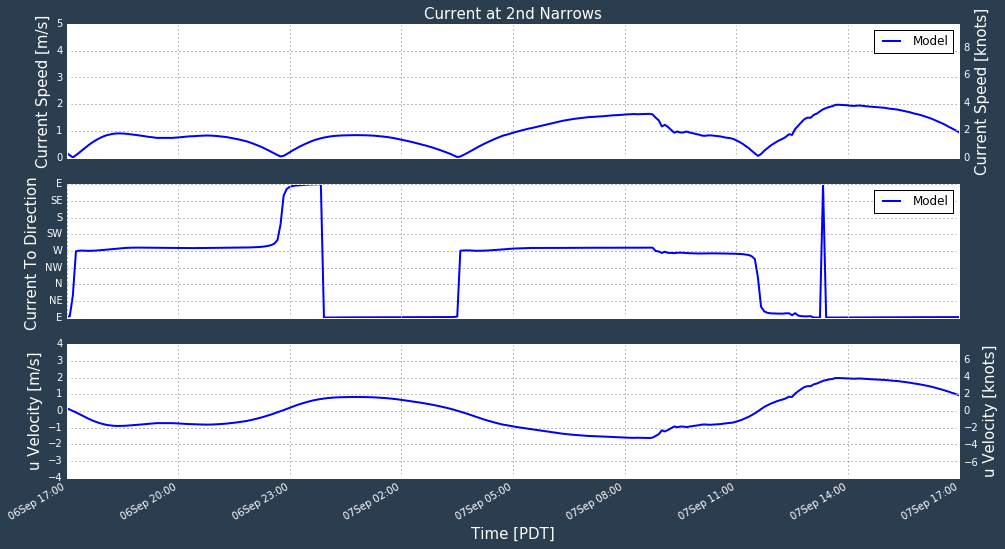

In [19]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

run_type = 'nowcast'
run_date = arrow.get('2018-09-07')

fvcom_stn_dataset_path_tmpl = (
    '/opp/fvcom/{run_type}/{ddmmmyy}/vhfr_low_v2_station_timeseries.nc'
)
if run_type == 'nowcast':
    fvcom_stn_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
else:
    nowcast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='nowcast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    forecast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='forecast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    fvcom_stn_dataset_path = Path('/tmp/vhfr_low_v2_station_timeseries_forecast.nc')
    cmd = (
        f'ncrcat {nowcast_dataset_path} {forecast_dataset_path} '
        f'-o {fvcom_stn_dataset_path}'
    )
    subprocess.check_output(shlex.split(cmd))
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_stn_dataset_path} /tmp/{fvcom_stn_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_stn_dataset = xarray.open_dataset(f'/tmp/{fvcom_stn_dataset_path.name}')

fig = make_figure(
    '2nd Narrows', fvcom_stn_dataset,
)

### Forecast Figure

551 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


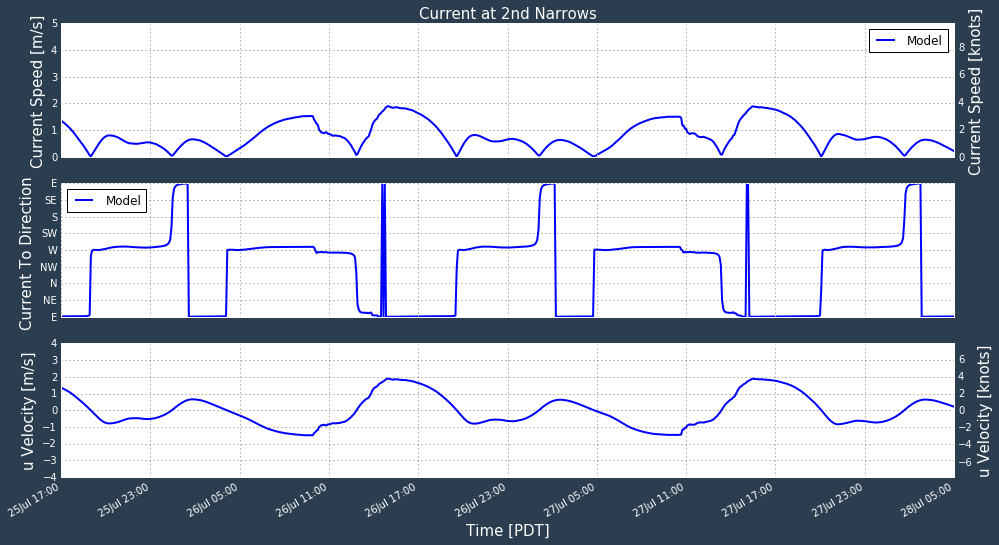

In [20]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

run_type = 'forecast'
run_date = arrow.get('2018-07-26')

fvcom_stn_dataset_path_tmpl = (
    '/opp/fvcom/{run_type}/{ddmmmyy}/vhfr_low_v2_station_timeseries.nc'
)
if run_type == 'nowcast':
    fvcom_stn_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type=run_type, ddmmmyy=run_date.format("DDMMMYY").lower())
    )
else:
    nowcast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='nowcast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    forecast_dataset_path = Path(
        fvcom_stn_dataset_path_tmpl.format(
            run_type='forecast', ddmmmyy=run_date.format("DDMMMYY").lower())
    )
    fvcom_stn_dataset_path = Path('/tmp/vhfr_low_v2_station_timeseries_forecast.nc')
    cmd = (
        f'ncrcat -O {nowcast_dataset_path} {forecast_dataset_path} -o {fvcom_stn_dataset_path}')
    subprocess.check_output(shlex.split(cmd))
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_stn_dataset_path} /tmp/{fvcom_stn_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_stn_dataset = xarray.open_dataset(f'/tmp/{fvcom_stn_dataset_path.name}')

fig = make_figure('2nd Narrows', fvcom_stn_dataset)